# Convolutional Neural Networks - Build Model
---
In this notebook, we build and train a **CNN** to classify images from the CIFAR-10 database.
* The code provided here are **almost** working. You are required to build up a CNN model and train it.
* Make sure you covered implementations of the **TODO**s in this notebook

The images in this database are small color images that fall into one of ten classes; some example images are pictured below.

<img src='cifar_data.png' width=50% height=50% />

### Optional: Use [CUDA](http://pytorch.org/docs/stable/cuda.html) if Available

Since these are color (32x32x3) images, it may prove useful to speed up your training time by using a GPU. CUDA is a parallel computing platform and CUDA Tensors are the same as typical Tensors, but they utilize GPU's for effcient parallel computation.

In [6]:
import torch
import numpy as np

# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


## Load the [Data](http://pytorch.org/docs/stable/torchvision/datasets.html)
---
Downloading may take a minute. We load in the training and test data, split the training data into a training and validation set, then create DataLoaders for each of these sets of data.

In [7]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# number of subprocesses to use for data loading
num_workers = 0
# how many samples per batch to load
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
    sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,
    num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170M/170M [00:02<00:00, 61.9MB/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


### Visualize a Batch of Training Data

In [8]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

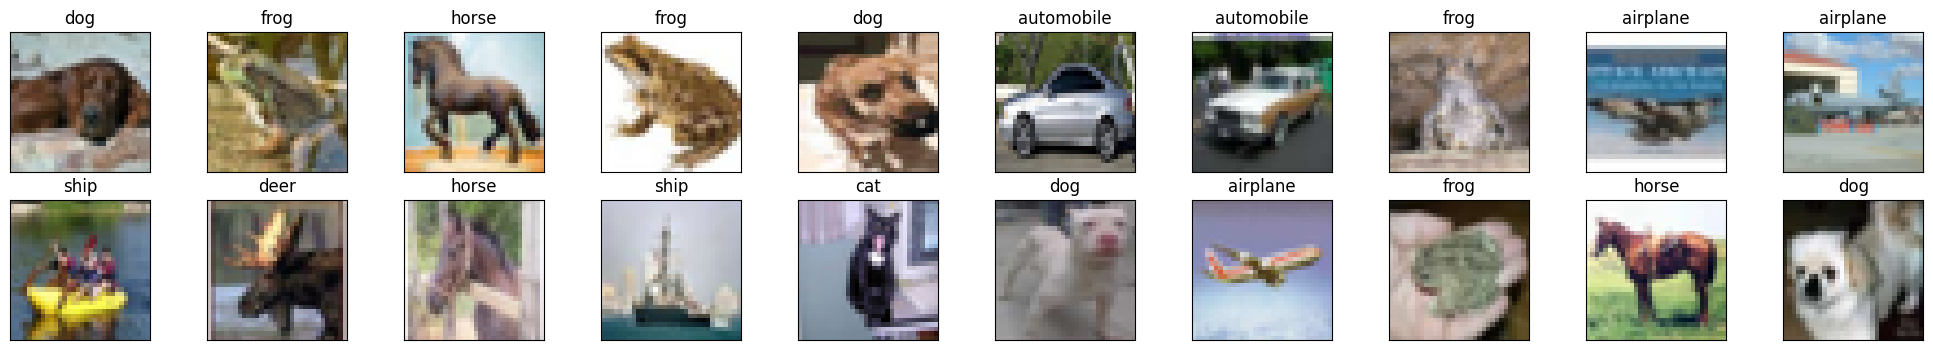

In [9]:
# obtain one batch of training images
dataiter = iter(train_loader)
#images, labels = dataiter.next() #python, torchvision version match issue
images, labels = next(dataiter)
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

### View an Image in More Detail

Here, we look at the normalized red, green, and blue (RGB) color channels as three separate, grayscale intensity images.

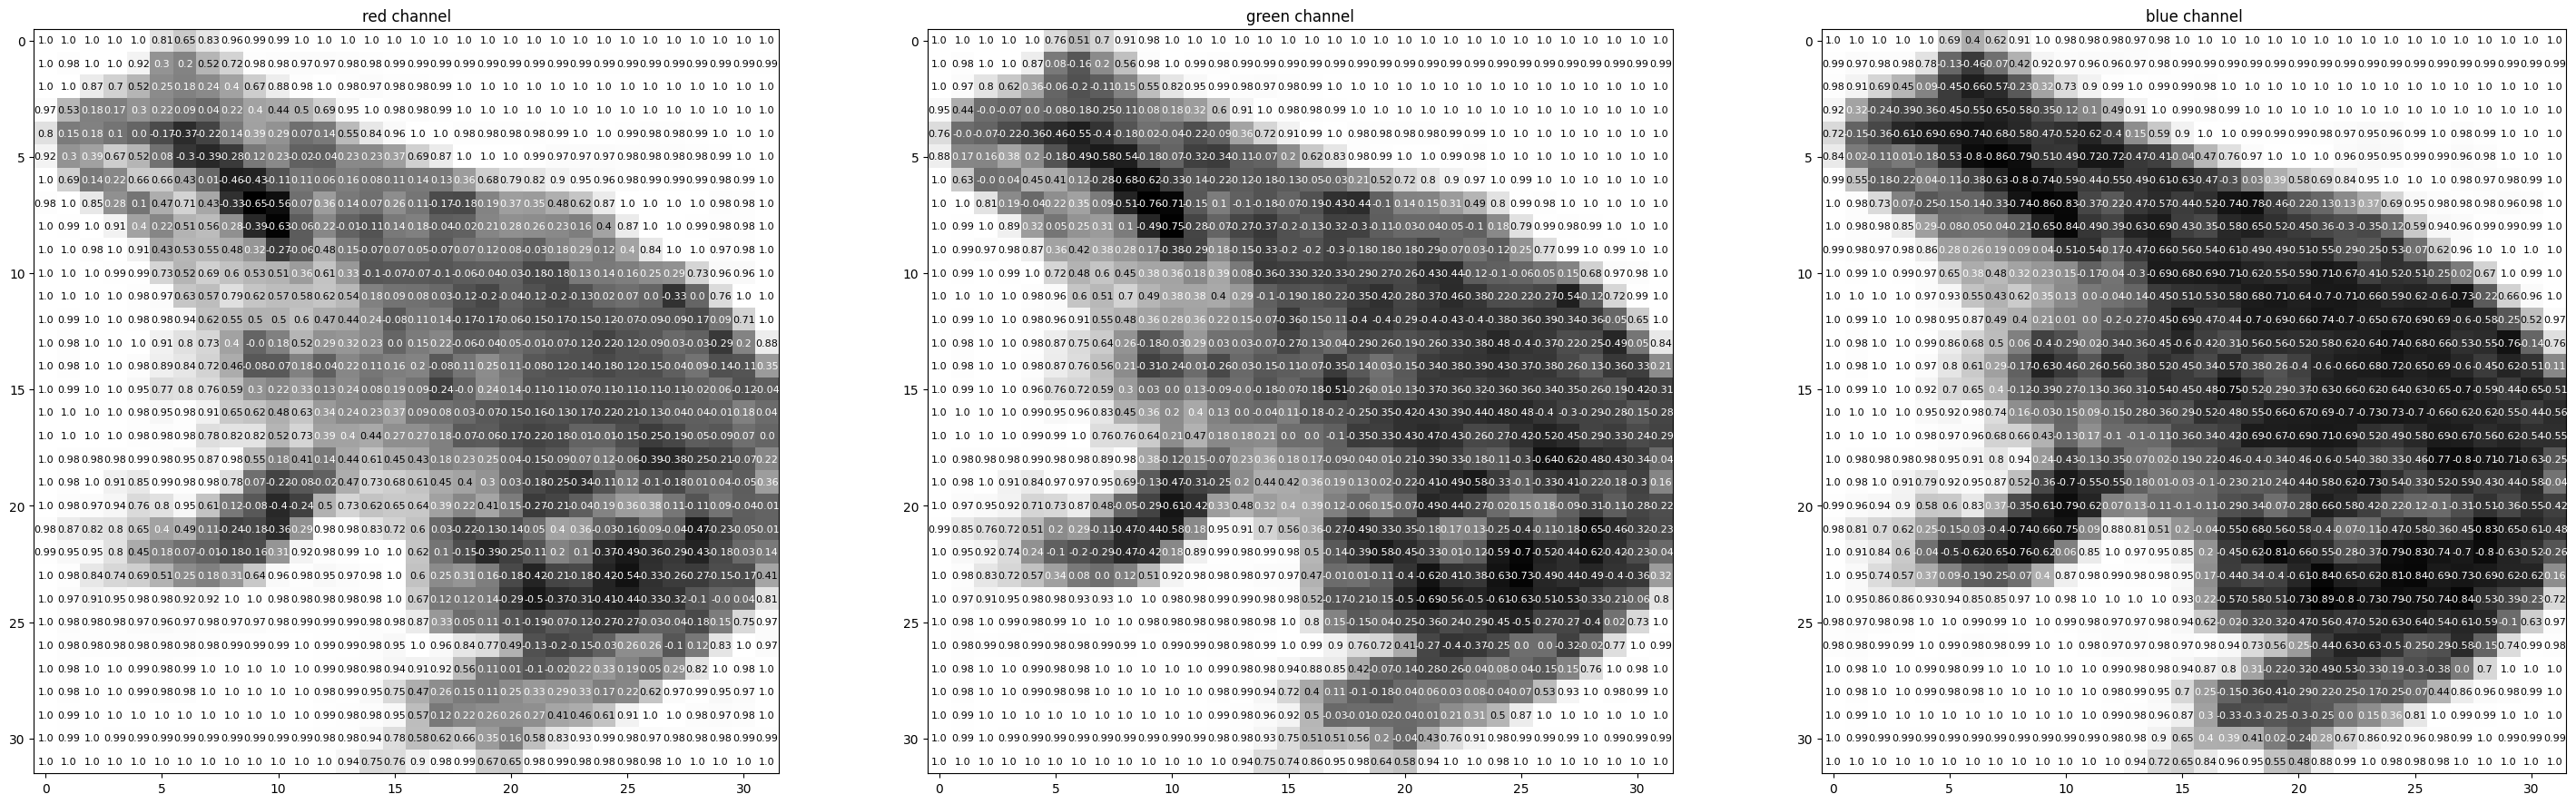

In [10]:
rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36))
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(1, 3, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

## **TODO**: Define the Network [Architecture](http://pytorch.org/docs/stable/nn.html)
---
Build up your own Convolutional Neural Network using Pytorch API:
- nn.Conv2d(): for convolution
- nn.MaxPool2d(): for maxpooling (spatial resolution reduction)
- nn.Linear(): for last 1 or 2 layers of fully connected layer before the output layer.
- nn.Dropout(): optional, [dropout](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html) can be used to avoid overfitting.
- F.relu(): Use ReLU as the activation function for all the hidden layers

The following is a skeleton example that's not completely working.

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import numpy as np


# Define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)  # Input: 3 channels (RGB), Output: 32 channels
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)  # Input: 32 channels, Output: 64 channels
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)  # Input: 64 channels, Output: 128 channels

        # Max pooling layer (to reduce spatial dimensions)
        self.pool = nn.MaxPool2d(2, 2)

        # Fully connected layers (linear layers)
        self.fc1 = nn.Linear(128 * 4 * 4, 512)  # After conv and pooling, the size is 128x4x4 for CIFAR-10 images
        self.fc2 = nn.Linear(512, 10)  # Output layer, 10 classes for CIFAR-10

        # Dropout layer to reduce overfitting
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # Add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))  # Convolutional layer 1 followed by ReLU and max pooling
        x = self.pool(F.relu(self.conv2(x)))  # Convolutional layer 2 followed by ReLU and max pooling
        x = self.pool(F.relu(self.conv3(x)))  # Convolutional layer 3 followed by ReLU and max pooling

        # Flatten the tensor to prepare for fully connected layer
        x = x.view(-1, 128 * 4 * 4)  # Flatten: batch_size x (128 * 4 * 4)

        # Add dropout (optional)
        x = self.dropout(x)

        # Fully connected layers
        x = F.relu(self.fc1(x))  # First fully connected layer with ReLU activation
        x = self.fc2(x)  # Second fully connected layer (output layer)

        return x


### Specify [Loss Function](http://pytorch.org/docs/stable/nn.html#loss-functions) and [Optimizer](http://pytorch.org/docs/stable/optim.html)
---
Decide on a loss and optimization function that is best suited for this classification task. The linked code examples from above, may be a good starting point; [this PyTorch classification example](https://github.com/pytorch/tutorials/blob/master/beginner_source/blitz/cifar10_tutorial.py) Pay close attention to the value for **learning rate** as this value determines how your model converges to a small error.

The following is working code, but you can make your own adjustments.

**TODO**: try to compare with ADAM optimizer

In [12]:
import torch.optim as optim

# Define the model
model = Net()

# Choose the optimizer
# Option 1: SGD optimizer
optimizer_sgd = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)

# Option 2: Adam optimizer (this one generally works better in practice)
optimizer_adam = optim.Adam(model.parameters(), lr=0.001)


## Train the Network
---
Remember to look at how the training and validation loss decreases over time; if the validation loss ever increases it indicates possible overfitting.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [13]:
# Specify loss function
criterion = nn.CrossEntropyLoss()

# Number of epochs
n_epochs = 5

valid_loss_min = np.Inf  # Track change in validation loss

# Use the optimizer you want to compare
optimizer = optimizer_sgd  # or optimizer_adam

# Training loop
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0

    ###################
    # Train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update weights

        train_loss += loss.item() * data.size(0)

    ######################
    # Validate the model #
    ######################
    model.eval()
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss
        valid_loss += loss.item() * data.size(0)

    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")

    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), "model_trained.pt")
        valid_loss_min = valid_loss


Epoch: 1 	Training Loss: 1.532262 	Validation Loss: 1.187616
Validation loss decreased (inf --> 1.187616). Saving model...
Epoch: 2 	Training Loss: 1.077215 	Validation Loss: 0.975992
Validation loss decreased (1.187616 --> 0.975992). Saving model...
Epoch: 3 	Training Loss: 0.883377 	Validation Loss: 0.847778
Validation loss decreased (0.975992 --> 0.847778). Saving model...
Epoch: 4 	Training Loss: 0.760616 	Validation Loss: 0.764287
Validation loss decreased (0.847778 --> 0.764287). Saving model...
Epoch: 5 	Training Loss: 0.666451 	Validation Loss: 0.806002


###  Load the Model with the Lowest Validation Loss
This is the model we will use for testing, which is the model we saved in the last step

In [14]:
model.load_state_dict(torch.load('model_trained.pt'))

<ipython-input-14-1ebf1a10fb42>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_trained.pt'))


<All keys matched successfully>

## Test the Trained Network
---
Test your trained model on previously unseen data! Remember we have downloaded `train_data` and `test_data`. We will use `test_data` through `test_loader`.

A "good" result will be a CNN that gets around 70% (or more, try your best!) accuracy on these test images.

The following is working code, but you are encouraged to make your own adjustments and enhance the implementation.

In [15]:

# Test the model
test_loss = 0.0
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)

    _, pred = torch.max(output, 1)  # Get the predicted class
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = correct_tensor.cpu().numpy() if train_on_gpu else correct_tensor.numpy()

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}")

for i in range(10):
    if class_total[i] > 0:
        print(f"Test Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]}% ({class_correct[i]}/{class_total[i]})")

print(f"\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total)}%")


Test Loss: 0.779033
Test Accuracy of airplane: 79.7% (797/1000)
Test Accuracy of automobile: 81.4% (814/1000)
Test Accuracy of bird: 59.3% (593/1000)
Test Accuracy of cat: 55.9% (559/1000)
Test Accuracy of deer: 69.4% (694/1000)
Test Accuracy of dog: 68.0% (680/1000)
Test Accuracy of frog: 83.9% (839/1000)
Test Accuracy of horse: 78.0% (780/1000)
Test Accuracy of ship: 83.0% (830/1000)
Test Accuracy of truck: 77.8% (778/1000)

Test Accuracy (Overall): 73.64%


### Visualize Sample Test Results

The following is working code, but you are encouraged to make your own adjustments and enhance the visualization.

In [16]:
# Load the model with the lowest validation loss
model.load_state_dict(torch.load('model_trained.pt'))

# Test the model
test_loss = 0.0
class_correct = [0] * 10
class_total = [0] * 10

model.eval()
for batch_idx, (data, target) in enumerate(test_loader):
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()

    output = model(data)
    loss = criterion(output, target)
    test_loss += loss.item() * data.size(0)

    _, pred = torch.max(output, 1)  # Get the predicted class
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = correct_tensor.cpu().numpy() if train_on_gpu else correct_tensor.numpy()

    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

test_loss = test_loss / len(test_loader.dataset)
print(f"Test Loss: {test_loss:.6f}")

for i in range(10):
    if class_total[i] > 0:
        print(f"Test Accuracy of {classes[i]}: {100 * class_correct[i] / class_total[i]}% ({class_correct[i]}/{class_total[i]})")

print(f"\nTest Accuracy (Overall): {100. * np.sum(class_correct) / np.sum(class_total)}%")


<ipython-input-16-30e50598c549>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model_trained.pt'))


Test Loss: 0.779033
Test Accuracy of airplane: 79.7% (797/1000)
Test Accuracy of automobile: 81.4% (814/1000)
Test Accuracy of bird: 59.3% (593/1000)
Test Accuracy of cat: 55.9% (559/1000)
Test Accuracy of deer: 69.4% (694/1000)
Test Accuracy of dog: 68.0% (680/1000)
Test Accuracy of frog: 83.9% (839/1000)
Test Accuracy of horse: 78.0% (780/1000)
Test Accuracy of ship: 83.0% (830/1000)
Test Accuracy of truck: 77.8% (778/1000)

Test Accuracy (Overall): 73.64%


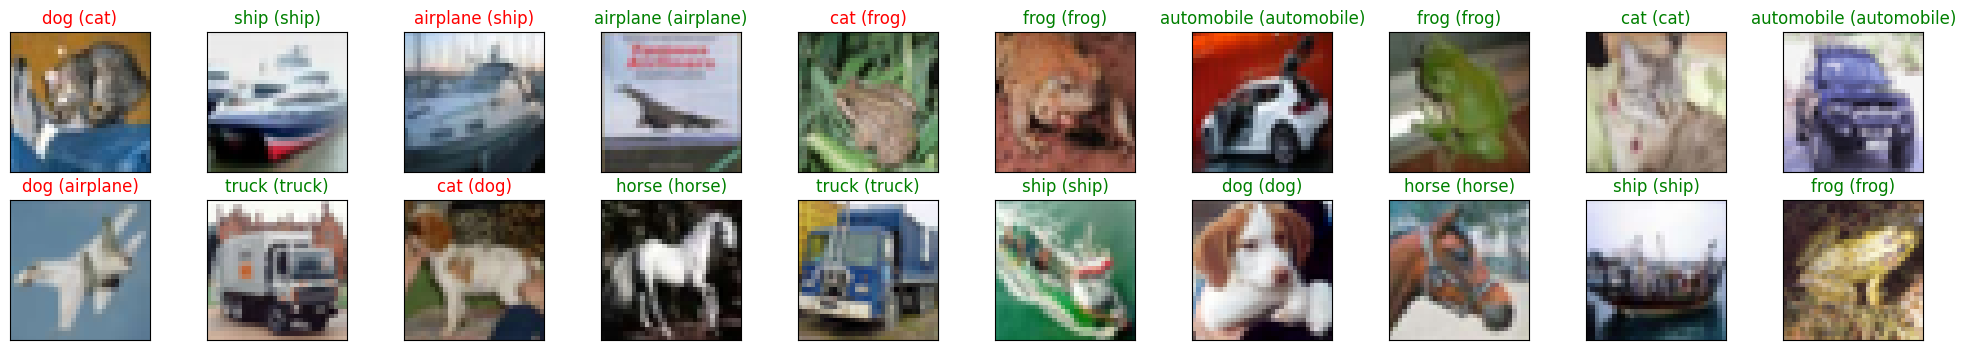

In [19]:
# Get sample test images
dataiter = iter(test_loader)
images, labels = next(dataiter)

if train_on_gpu:
    images = images.cuda()

# Get model predictions
output = model(images)
_, preds_tensor = torch.max(output, 1)
preds = preds_tensor.cpu().numpy() if train_on_gpu else preds_tensor.numpy()

# Display images with predictions
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(20):
    ax = fig.add_subplot(2, int(20 / 2), idx + 1, xticks=[], yticks=[])
    imshow(images[idx].cpu() if train_on_gpu else images[idx])
    ax.set_title(f"{classes[preds[idx]]} ({classes[labels[idx]]})",
                 color=("green" if preds[idx] == labels[idx].item() else "red"))


In [20]:
pip install torchviz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 12.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 800.0 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 79.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [24]:
from torchviz import make_dot
import torch

# Create a random input tensor with the same shape as CIFAR-10 images (32x32x3)
sample_input = torch.randn(1, 3, 32, 32)

# Forward pass through the model to get the computation graph
model.eval()  # Make sure the model is in evaluation mode
output = model(sample_input)

# Visualize the CNN architecture
dot = make_dot(output, params=dict(model.named_parameters()))
dot.render(filename="cnn_architecture", format="png")  # Save as .png

# Lists to store accuracy for each epoch
train_accuracies = []
valid_accuracies = []

# Training loop
for epoch in range(1, n_epochs + 1):
    train_loss = 0.0
    valid_loss = 0.0
    correct_train = 0
    total_train = 0

    ###################
    # Train the model #
    ###################
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        optimizer.zero_grad()  # Zero the gradients
        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss
        loss.backward()  # Backward pass (compute gradients)
        optimizer.step()  # Update weights

        train_loss += loss.item() * data.size(0)

        # Calculate training accuracy
        _, predicted = torch.max(output, 1)
        correct_train += (predicted == target).sum().item()
        total_train += target.size(0)

    # Calculate average training accuracy for this epoch
    train_accuracy = 100 * correct_train / total_train
    train_accuracies.append(train_accuracy)

    ######################
    # Validate the model #
    ######################
    model.eval()
    correct_valid = 0
    total_valid = 0
    for batch_idx, (data, target) in enumerate(valid_loader):
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()

        output = model(data)  # Forward pass
        loss = criterion(output, target)  # Calculate loss
        valid_loss += loss.item() * data.size(0)

        # Calculate validation accuracy
        _, predicted = torch.max(output, 1)
        correct_valid += (predicted == target).sum().item()
        total_valid += target.size(0)

    # Calculate average validation accuracy for this epoch
    valid_accuracy = 100 * correct_valid / total_valid
    valid_accuracies.append(valid_accuracy)

    # Calculate average losses
    train_loss = train_loss / len(train_loader.sampler)
    valid_loss = valid_loss / len(valid_loader.sampler)

    print(f"Epoch: {epoch} \tTraining Loss: {train_loss:.6f} \tValidation Loss: {valid_loss:.6f}")
    print(f"Epoch: {epoch} \tTraining Accuracy: {train_accuracy:.2f}% \tValidation Accuracy: {valid_accuracy:.2f}%")

    # Save the model if validation loss decreases
    if valid_loss <= valid_loss_min:
        print(f"Validation loss decreased ({valid_loss_min:.6f} --> {valid_loss:.6f}). Saving model...")
        torch.save(model.state_dict(), "model_trained.pt")
        valid_loss_min = valid_loss




Epoch: 1 	Training Loss: 0.659731 	Validation Loss: 0.806362
Epoch: 1 	Training Accuracy: 76.95% 	Validation Accuracy: 72.75%
Epoch: 2 	Training Loss: 0.585499 	Validation Loss: 0.801401
Epoch: 2 	Training Accuracy: 79.67% 	Validation Accuracy: 73.11%
Epoch: 3 	Training Loss: 0.524849 	Validation Loss: 0.857809
Epoch: 3 	Training Accuracy: 81.75% 	Validation Accuracy: 72.08%
Epoch: 4 	Training Loss: 0.487799 	Validation Loss: 0.823084
Epoch: 4 	Training Accuracy: 83.10% 	Validation Accuracy: 74.06%
Epoch: 5 	Training Loss: 0.445246 	Validation Loss: 0.865964
Epoch: 5 	Training Accuracy: 84.64% 	Validation Accuracy: 72.44%


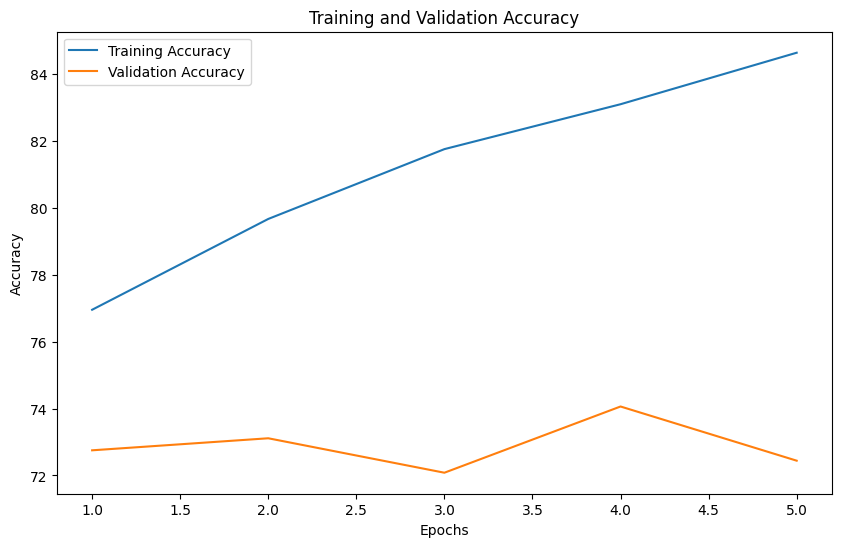

In [25]:
# Plotting training and validation accuracy
epochs = range(1, n_epochs + 1)

plt.figure(figsize=(10, 6))
plt.plot(epochs, train_accuracies, label='Training Accuracy')
plt.plot(epochs, valid_accuracies, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()